# 1. Intro to Waveforms

This tutorial demonstrates how to use PyART's waveform class

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# logging configuration, default INFO level
from PyART.logging_config import setup_logging
setup_logging()

# Set up Seaborn aesthetics
sns.set_context('talk') 
sns.set_theme(font_scale=1.2)
sns.set_style('ticks')

# Update matplotlib rcParams
rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        'axes.grid': True,
        'grid.linestyle': ':',
        'grid.color': '#bbbbbb',
        'axes.linewidth': 1,
    }
)

We now create an empty Waveform object and inspect its attributes.
This class is inherited by all waveform catalogs and models, meaning that they will *all* have these attributes and methods.  
For more information, see the [Waveform class documentation](https://roxgamba.github.io/PyART/autoapi/PyART/waveform/index.html).

In [2]:
from PyART.waveform import Waveform

# Create an empty Waveform object
waveform = Waveform()

attributes = [attr for attr in dir(waveform) if not attr.startswith('_') and not callable(getattr(waveform, attr))]
methods = [method for method in dir(waveform) if not method.startswith('_') and callable(getattr(waveform, method))]

print("Attributes of the Waveform object:")
for attr in attributes:
    print(f"- {attr}")

print("\nMethods of the Waveform object:")
for method in methods:
    print(f"- {method}")

Attributes of the Waveform object:
- dothlm
- dyn
- f
- hc
- hlm
- hp
- kind
- psi4lm
- t
- t_psi4
- u

Methods of the Waveform object:
- compute_dothlm
- compute_hphc
- compute_psi4lm
- cut
- dynamics_from_hlm
- ej_from_hlm
- find_max
- integrate_data
- interpolate_hlm
- multiply_by
- to_frequency


We now load a waveform from the SXS catalog and plot its modes $h_{\ell m}$.  
They are stored as a dictionary of the form: `hlm[(l,m)]`. Each dictionary entry has the amplitude: `A` and phase `p` of the mode, as well as the `real` and `imag` part of $h_{\ell,m}$.

Note that, by default, the modes are *not* interpolated to a uniform time grid. Therefore, before plotting, we:
- Interpolate to a uniform time grid with `waveform.interpolate_hlm`
- Shift the time array so that the (2,2) mode peaks at $t=0M$, using the `find_max` method.

Is the time array uniform? False
Is the time array uniform? True


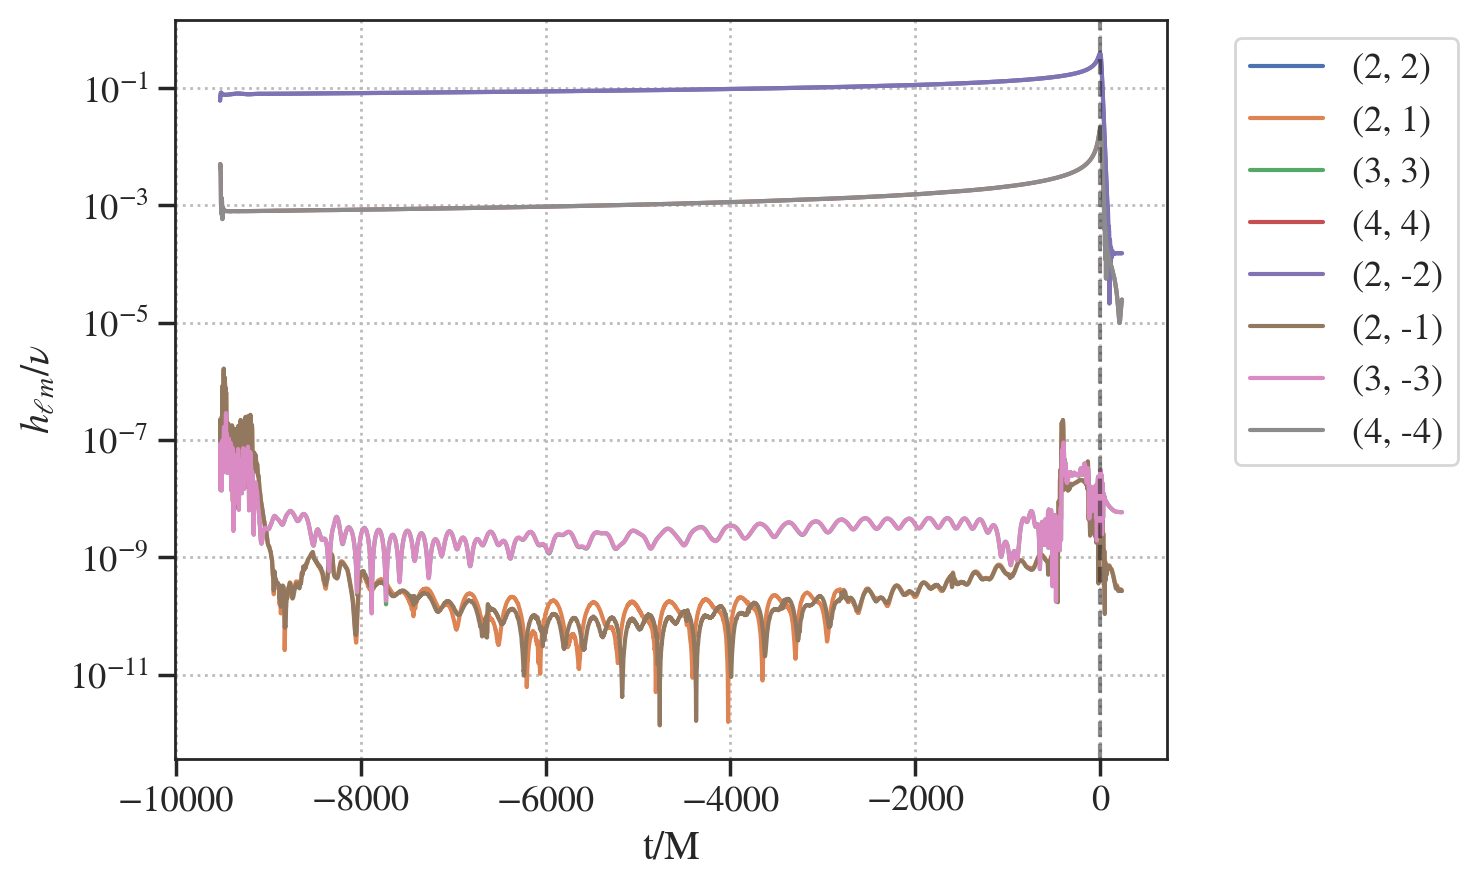

In [38]:
from PyART.catalogs import sxs

# Utility function to check if an array is uniformly spaced
def is_uniform(arr, rtol=1e-10, atol=1e-12):
    delta = np.diff(arr)
    return np.allclose(delta, delta[0], rtol=rtol, atol=atol)

sxs_waveform = sxs.Waveform_SXS(ID='0180',
                                download=True,
                                ignore_deprecation=True,
                                downloads=["hlm", "metadata", "horizons"],
                                load=["hlm", "metadata", "horizons"]
                                )


# verify that the time array is uniform
print("Is the time array uniform?", is_uniform(sxs_waveform.u))

# interpolate to uniform time gri, dT = 1M
t_interp, hlm_interp = sxs_waveform.interpolate_hlm(1)

# overwrite time array and modes in the waveform object
sxs_waveform._t = t_interp
sxs_waveform._u = t_interp
sxs_waveform._hlm = hlm_interp

# verify that the time array is uniform
print("Is the time array uniform?", is_uniform(sxs_waveform.u))

t_max, _, _, _, mrg_idx = sxs_waveform.find_max(return_idx=True, mode=(2,2))

fig, ax = plt.subplots()
modes = [(2, 2), (2, 1), (3, 3), (4, 4), (2, -2), (2, -1), (3, -3), (4, -4)]
for mode in modes:
    ax.semilogy(sxs_waveform.u-t_max, sxs_waveform.hlm[mode]['A'], label=f'{mode}')

# legend, out of box
ax.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('t/M')
ax.set_ylabel(r'$h_{\ell m}/\nu$')
plt.show()

We now use the modes to compute the energy and angular momentum radiated as a function of time.
To do so we use the `ej_from_hlm` method of the Waveform class.

Note that this method requires knowledge of the initial ADM mass and angular
momentum of the system, which are stored as attributes of the Waveform object (and automatically loaded, for most catalogs).

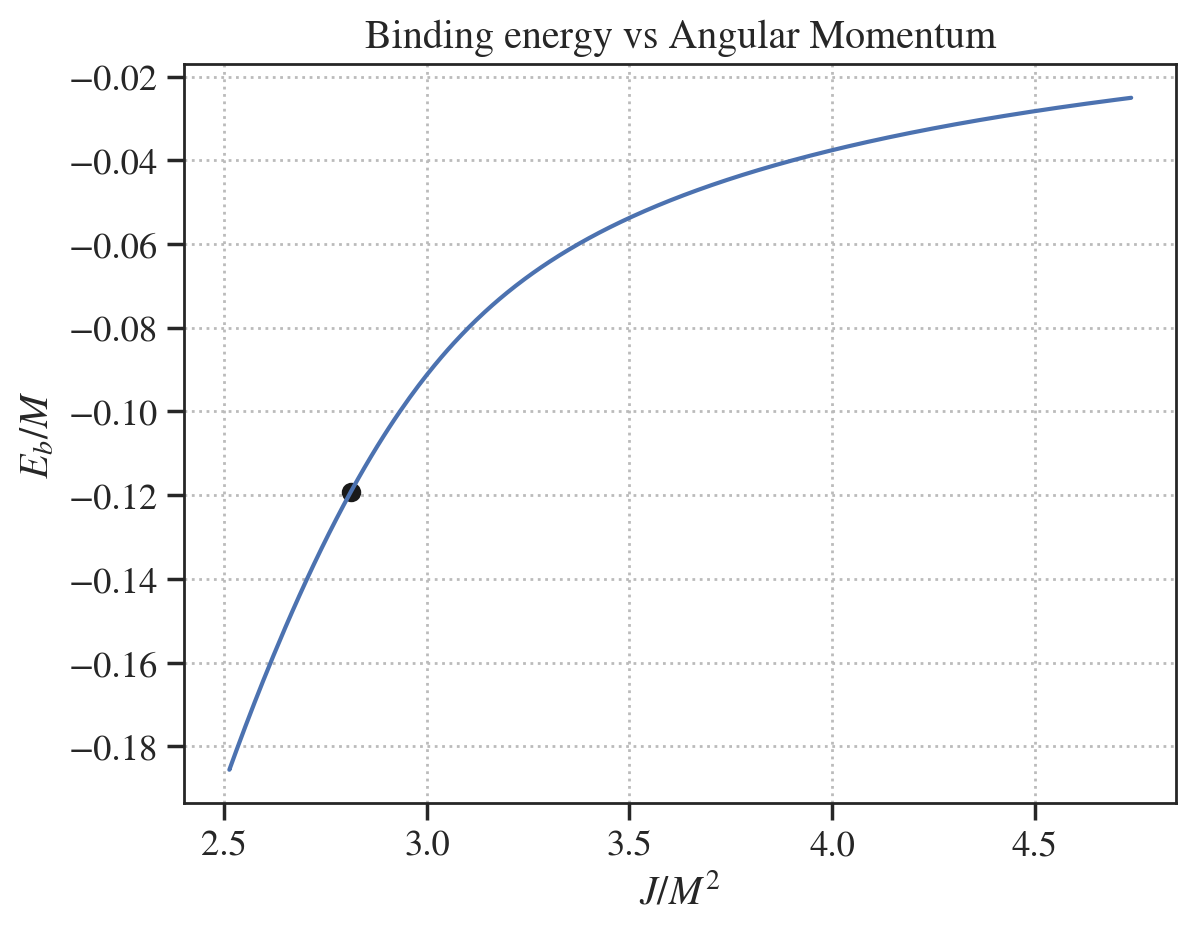

In [25]:
M_adm_0 = sxs_waveform.metadata['E0byM']
J_adm_0 = sxs_waveform.metadata['Jz0']
m1 = sxs_waveform.metadata['m1']
m2 = sxs_waveform.metadata['m2']

eb, e, jorb = sxs_waveform.ej_from_hlm(M_adm_0, J_adm_0, m1, m2, modes=modes)

# identify merger
e_mrg = eb[mrg_idx]
j_mrg = jorb[mrg_idx]

fig, ax = plt.subplots()
ax.plot(jorb, eb)
ax.set_xlabel(r'$J/M^2$')
ax.set_ylabel(r'$E_b/M$')
ax.scatter(j_mrg, e_mrg, color='k', label='Merger')
ax.set_title('Binding energy vs Angular Momentum')
plt.show()


We will now look at the dynamics. This is not available for all catalogs/models. In the case of SXS waveforms, we do load Horizon data when we download the waveform and can access it.

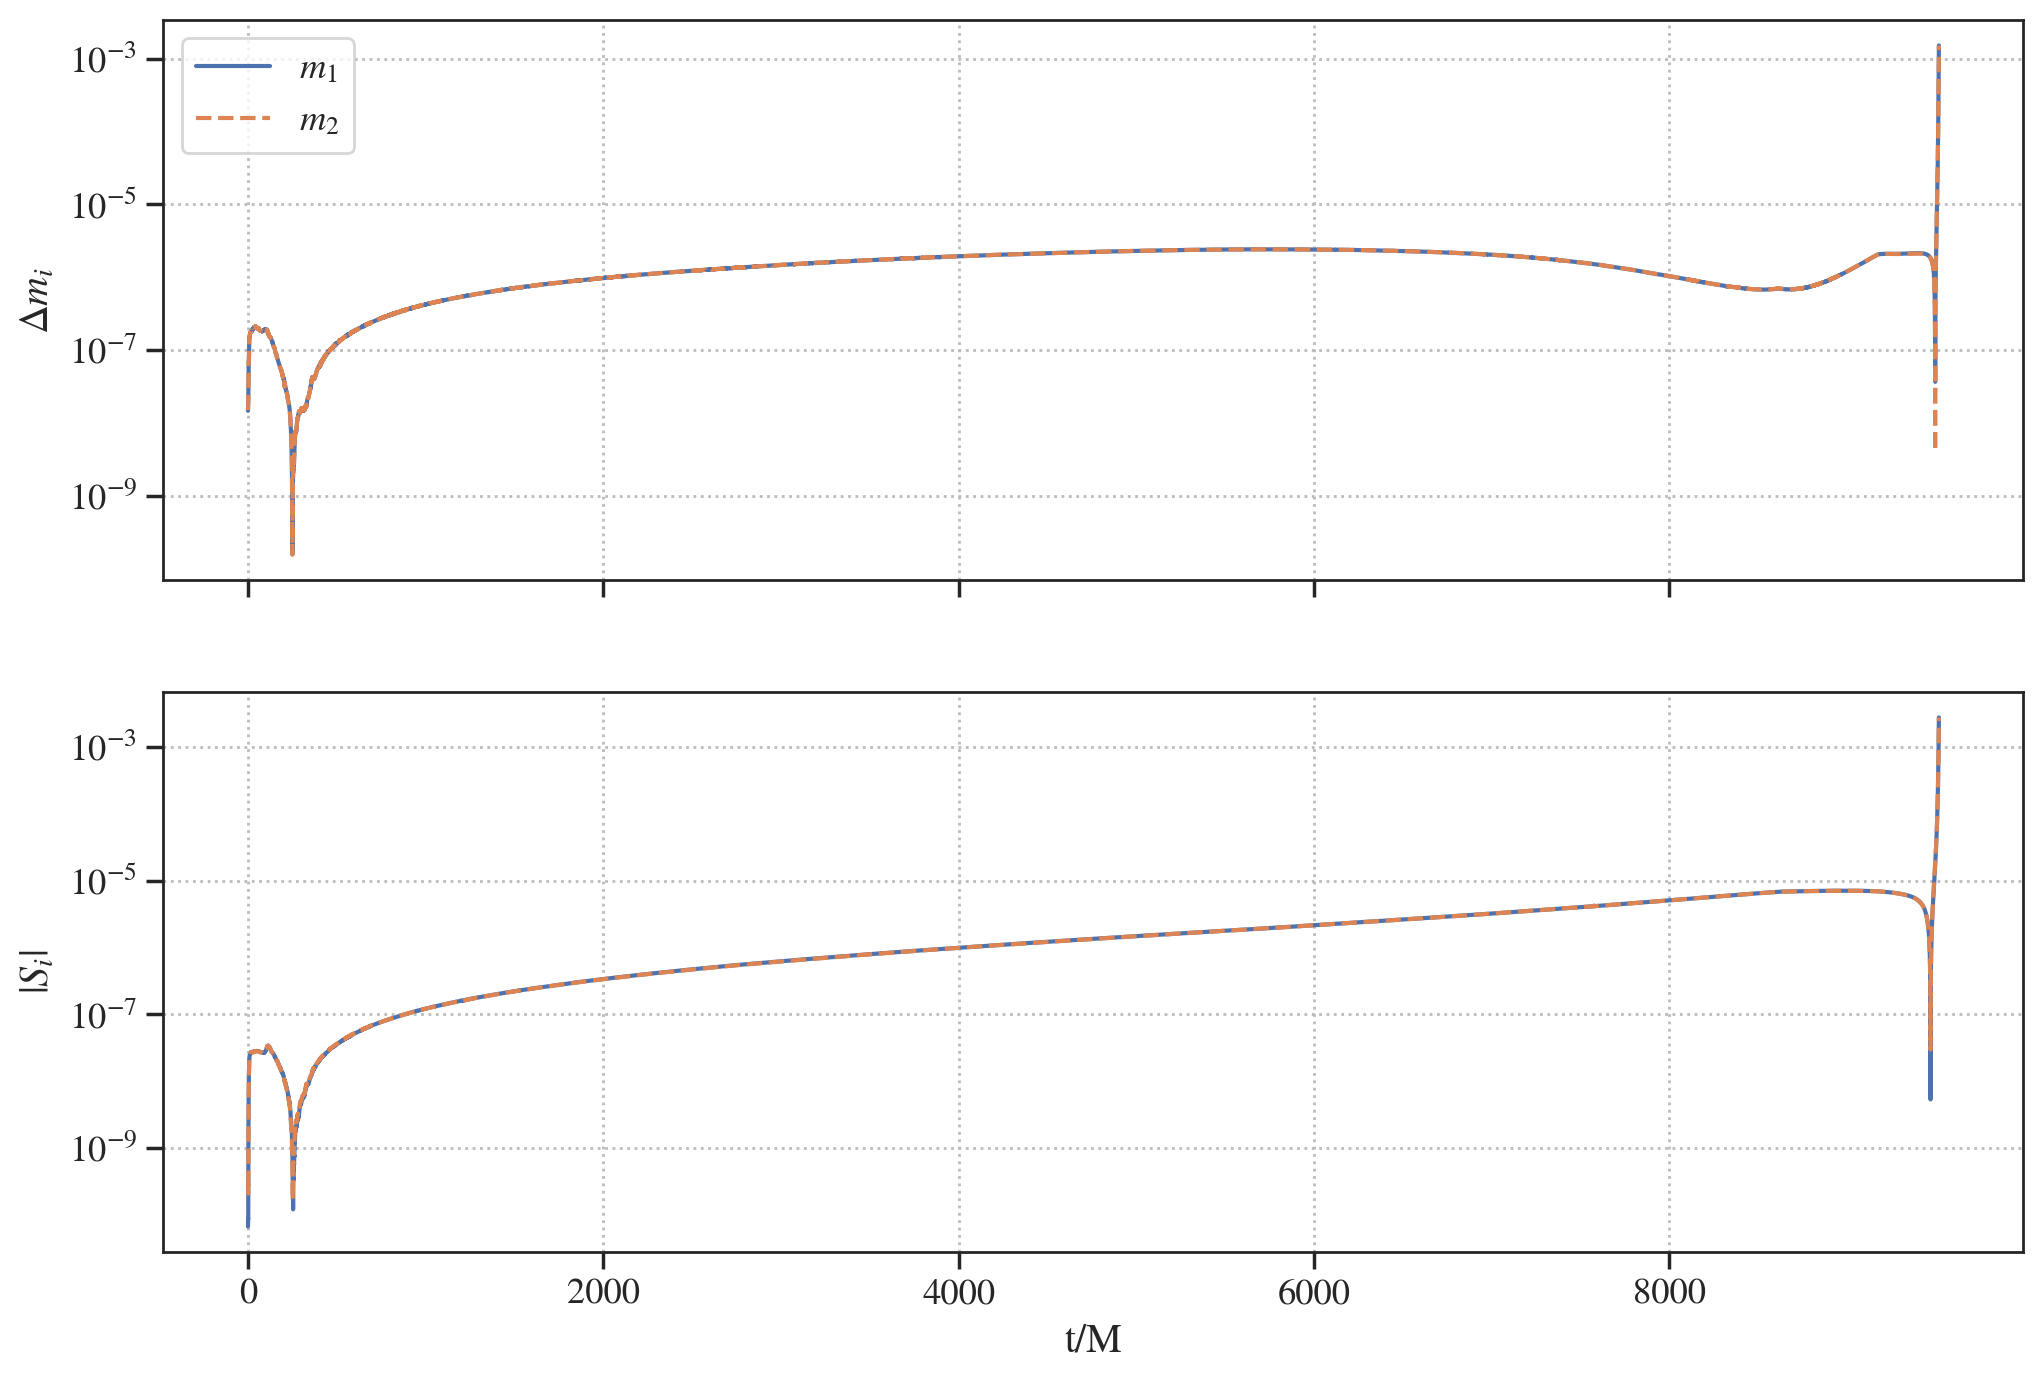

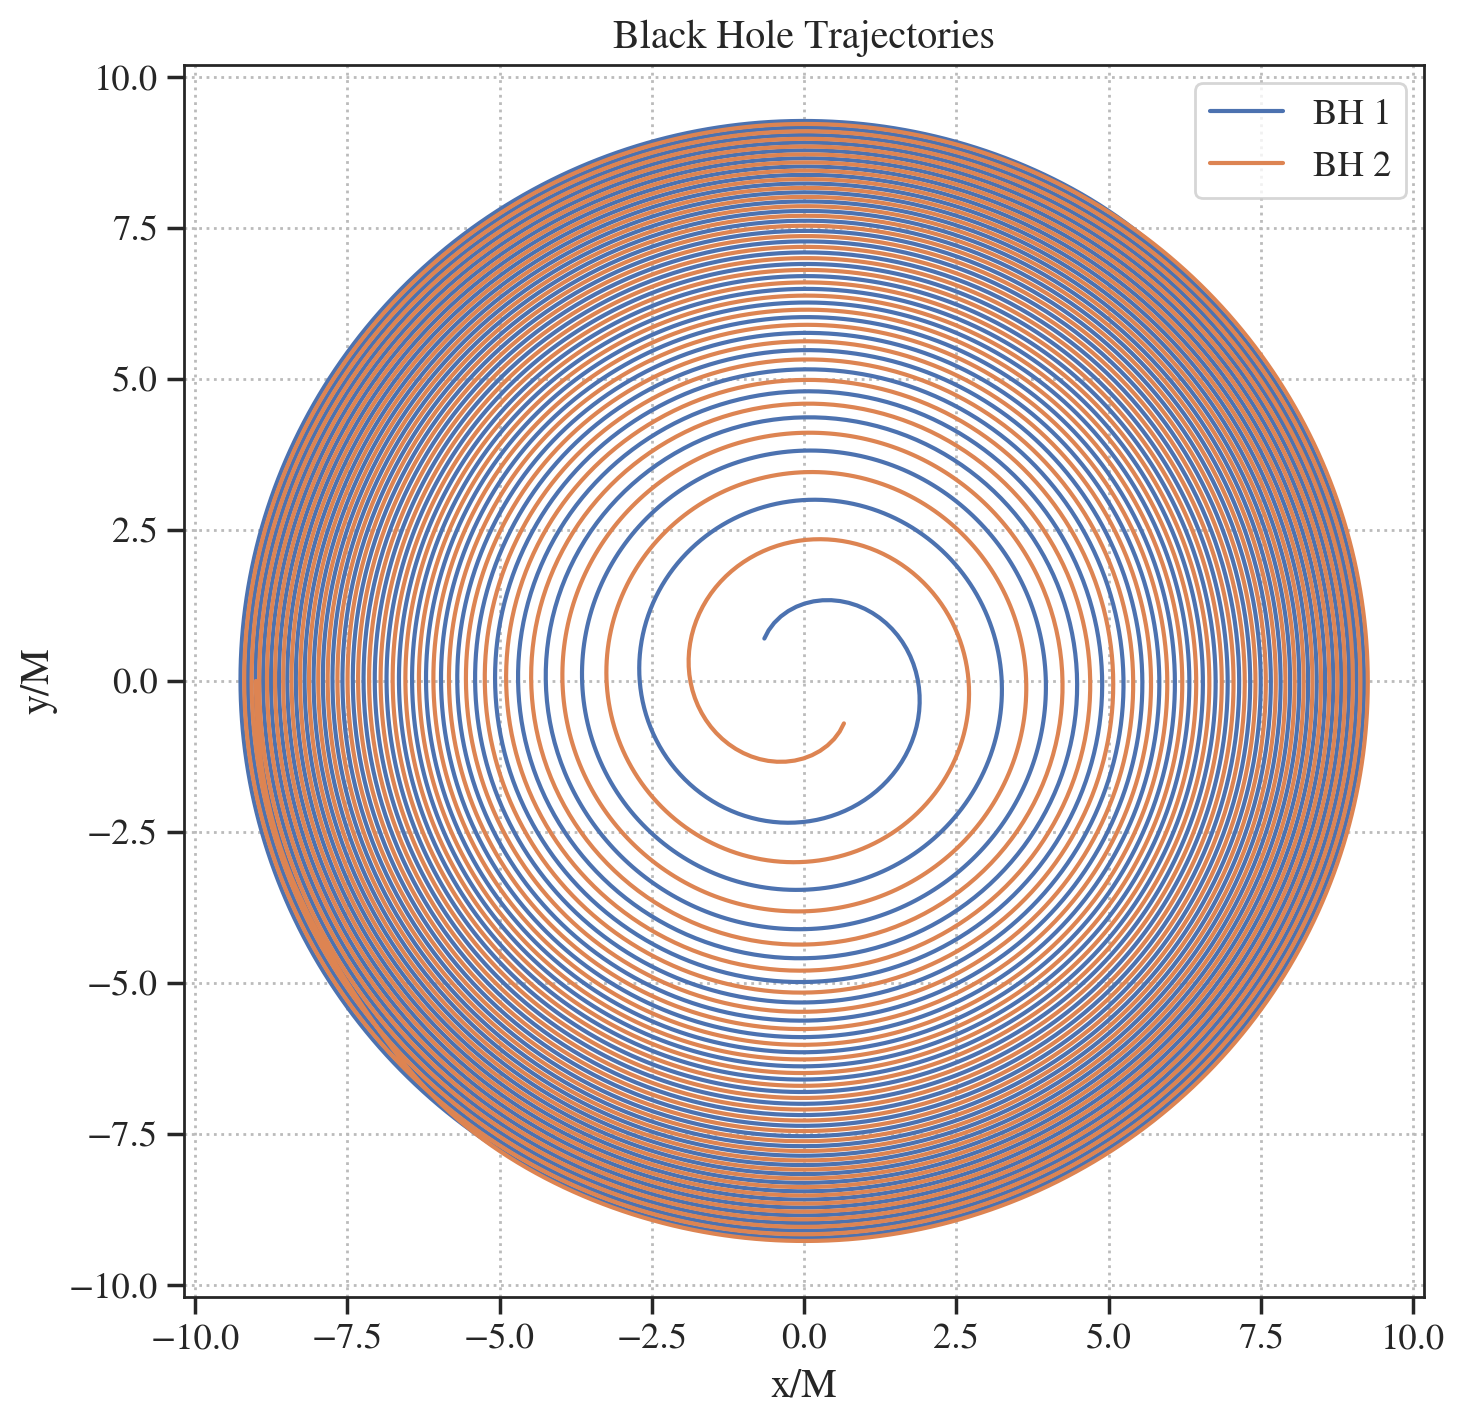

In [40]:
# plot the mass / spin evolution
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axs[0].semilogy(sxs_waveform.dyn['t'], abs(sxs_waveform.dyn['m1']-m1), label=r'$m_1$')
axs[0].semilogy(sxs_waveform.dyn['t'], abs(sxs_waveform.dyn['m2']-m2), label=r'$m_2$', linestyle='--')
axs[1].semilogy(sxs_waveform.dyn['t'], sxs_waveform.dyn['chi1'], label=r'S_1')
axs[1].semilogy(sxs_waveform.dyn['t'], sxs_waveform.dyn['chi2'], label=r'S_2', linestyle='--')
axs[0].set_ylabel(r'$\Delta m_i$')
axs[1].set_ylabel(r'$|S_i|$')
axs[1].set_xlabel('t/M')
axs[0].legend()
plt.show()


# plot the trajectories
xA = sxs_waveform.dyn['x1']
xB = sxs_waveform.dyn['x2']
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(xA[:, 0], xA[:, 1], label='BH 1')
ax.plot(xB[:, 0], xB[:, 1], label='BH 2')
ax.set_xlabel('x/M')
ax.set_ylabel('y/M')
ax.set_title('Black Hole Trajectories')
ax.legend()
plt.show()
